In [1]:
import json

import numpy as np
import cv2

from PIL import Image

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm

In [3]:
batch_size = 32
image_dir = 'ap-10k/data/'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# Prepare data

Dataset: [AP-10K](https://github.com/AlexTheBad/AP-10K)

In [5]:
split1 = json.load(open('ap-10k/annotations/ap10k-train-split1.json'))

In [6]:
split1.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [26]:
split1['images'][0]

{'license': 1,
 'id': 371,
 'file_name': '000000000371.jpg',
 'width': 1024,
 'height': 768,
 'background': 2}

In [27]:
split1['annotations'][0]

{'id': 441,
 'image_id': 371,
 'category_id': 1,
 'bbox': [255, 209, 483, 387],
 'area': 186921,
 'iscrowd': 0,
 'num_keypoints': 16,
 'keypoints': [0,
  0,
  0,
  681,
  464,
  2,
  687,
  527,
  2,
  612,
  380,
  2,
  312,
  257,
  2,
  501,
  401,
  2,
  516,
  467,
  2,
  528,
  542,
  2,
  570,
  401,
  2,
  627,
  449,
  2,
  612,
  539,
  2,
  321,
  362,
  2,
  276,
  404,
  2,
  282,
  548,
  2,
  357,
  374,
  2,
  321,
  428,
  2,
  348,
  563,
  2]}

In [7]:
category = [cat for cat in split1['categories'] if cat['name'] == 'dog'][0]

In [8]:
category

{'id': 8,
 'name': 'dog',
 'supercategory': 'Canidae',
 'keypoints': ['left_eye',
  'right_eye',
  'nose',
  'neck',
  'root_of_tail',
  'left_shoulder',
  'left_elbow',
  'left_front_paw',
  'right_shoulder',
  'right_elbow',
  'right_front_paw',
  'left_hip',
  'left_knee',
  'left_back_paw',
  'right_hip',
  'right_knee',
  'right_back_paw'],
 'skeleton': [[1, 2],
  [1, 3],
  [2, 3],
  [3, 4],
  [4, 5],
  [4, 6],
  [6, 7],
  [7, 8],
  [4, 9],
  [9, 10],
  [10, 11],
  [5, 12],
  [12, 13],
  [13, 14],
  [5, 15],
  [15, 16],
  [16, 17]]}

In [9]:
def get_annotations(name):
    annotations = []
    for i in range(1, 4):
        split = json.load(open(f'ap-10k/annotations/ap10k-{name}-split{i}.json'))
        id2filename = {image['id']:image['file_name'] for image in split['images']}
        for anno in split['annotations']:
            if anno['category_id'] == category['id']:
                anno['file_name'] = id2filename[anno['image_id']]
                annotations.append(anno)
    return annotations

In [10]:
train = get_annotations('train')
val = get_annotations('val')

In [11]:
print('Train:', len(train))
print('Val:', len(val))

Train: 2368
Val: 339


# ANNOTATIONS
Annotations for keypoints are just like in Object Detection (Segmentation) above, except a number of keypoints is specified in sets of 3, (x, y, v).

x and y indicate pixel positions in the image.

v indicates visibility— v=0: not labeled (in which case x=y=0), v=1: labeled but not visible, and v=2: labeled and visible  

229, 256, 2 means there’s a keypoint at pixel x=229, y=256 and 2 indicates that it is a visible keypoint

In [12]:
train[0]

{'id': 2498,
 'image_id': 8818,
 'category_id': 8,
 'bbox': [130, 25, 775, 647],
 'area': 501425,
 'iscrowd': 0,
 'num_keypoints': 3,
 'keypoints': [625,
  335,
  2,
  410,
  337,
  2,
  513,
  410,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'file_name': '000000008818.jpg'}

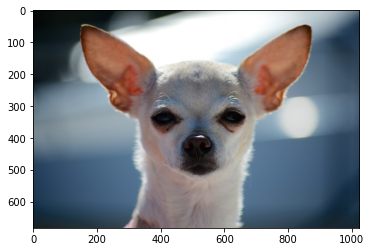

In [13]:
image = cv2.imread(f'{image_dir}/{train[0]["file_name"]}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

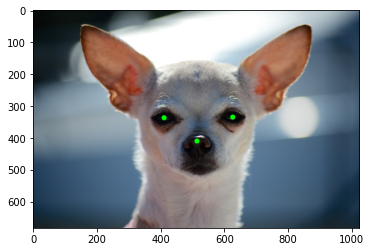

In [14]:
for i in range(0, len(train[0]['keypoints']), 3):
    if train[0]['keypoints'][i+2] != 0:
        cv2.circle(image, (train[0]['keypoints'][i], train[0]['keypoints'][i+1]), 0, (0, 255, 0), 15)
plt.imshow(image)

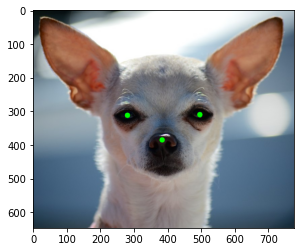

In [15]:
x_min = train[0]['bbox'][0]
x_max = train[0]['bbox'][0] + train[0]['bbox'][2]
y_min = train[0]['bbox'][1]
y_max = train[0]['bbox'][1] + train[0]['bbox'][3]
image = image[y_min:y_max,x_min:x_max]
plt.imshow(image)

In [16]:
class KeypointsDataset(Dataset):

    def __init__(self, meta):
        self.meta = meta
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = f"{image_dir}/{self.meta[idx]['file_name']}"
        image = Image.open(image_name).convert('RGB')
        image = np.asarray(image)
        
        x_min = self.meta[idx]['bbox'][0]
        x_max = self.meta[idx]['bbox'][0] + self.meta[idx]['bbox'][2]
        y_min = self.meta[idx]['bbox'][1]
        y_max = self.meta[idx]['bbox'][1] + self.meta[idx]['bbox'][3]
        image = image[y_min:y_max,x_min:x_max]

        image = self.preprocessing(image=image)['image']
            
        keypoints = []
        for i in range(0, len(self.meta[idx]['keypoints']), 3):
            keypoints.append((self.meta[idx]['keypoints'][i] - x_min) / (x_max - x_min))
            keypoints.append((self.meta[idx]['keypoints'][i+1] - y_min) / (y_max - y_min))
            keypoints.append(float(self.meta[idx]['keypoints'][i+2] > 0))

        return image, torch.Tensor(keypoints)

In [17]:
train_dataset = KeypointsDataset(meta=train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset = KeypointsDataset(meta=val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Metrics

## Object Keypoint Similarity

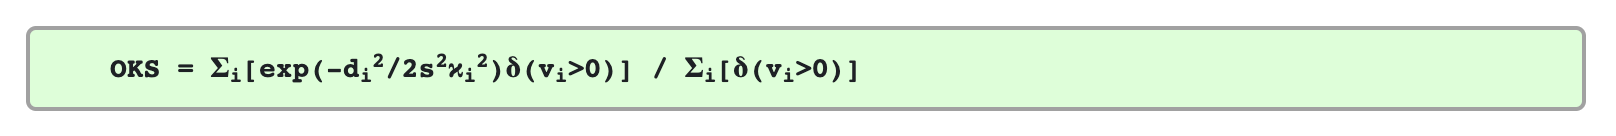

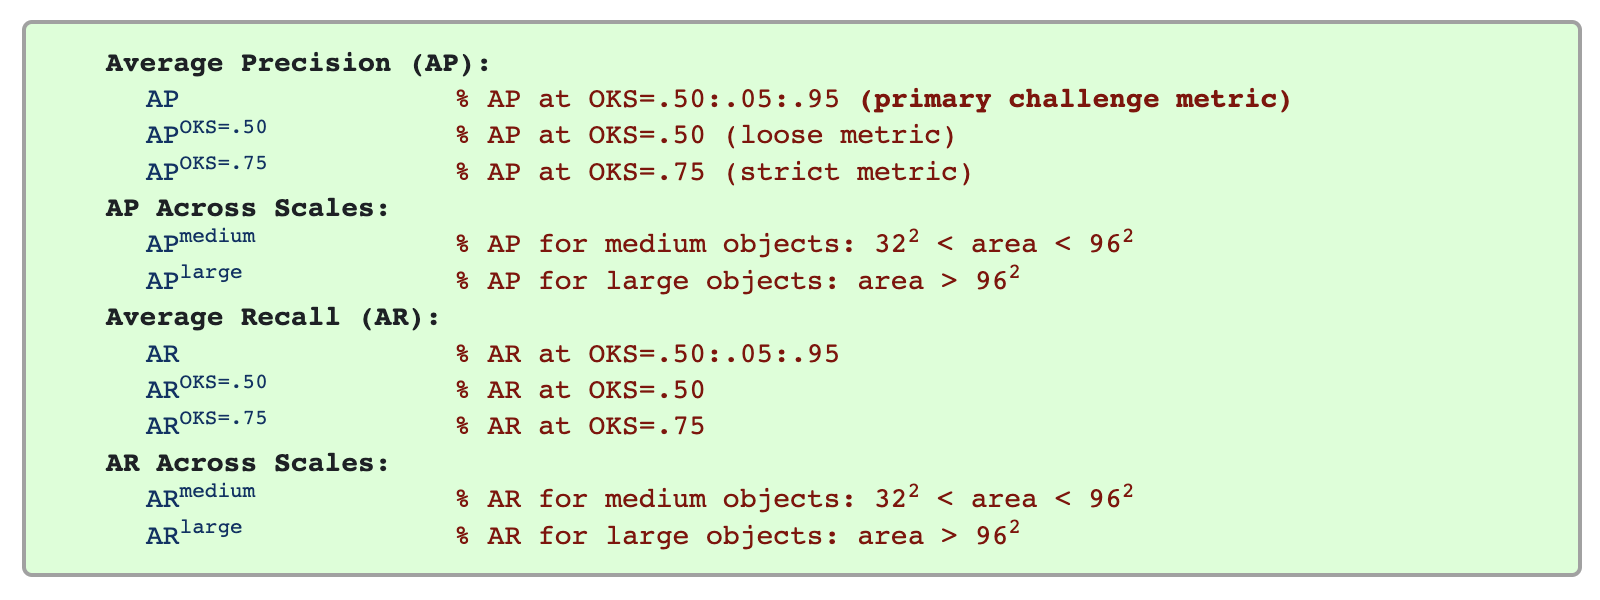

In [18]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

# Create model

In [19]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 51),
    nn.Sigmoid()
)
model.to(device);

# Train

In [20]:
EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [21]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 3)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 3)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 3)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))

Epoch: 0:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.210420072884173
Train OKS: 0.9293376097226262


Epoch: 0:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9649436933084783


Epoch: 1:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.13767973565169284
Train OKS: 0.9792009706406297


Epoch: 1:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9776172720947761


Epoch: 2:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.13106080308254506
Train OKS: 0.98496611077353


Epoch: 2:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9792791123378662


Epoch: 3:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.13009319180068937
Train OKS: 0.9860798595593029


Epoch: 3:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9798807509671807


Epoch: 4:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1291604133926936
Train OKS: 0.9877837690601582


Epoch: 4:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9816433074514497


Epoch: 5:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1285489561489305
Train OKS: 0.9889497205234283


Epoch: 5:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9814695766417443


Epoch: 6:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12809987466883016
Train OKS: 0.9897902647944339


Epoch: 6:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9828396468768468


Epoch: 7:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12773102914562096
Train OKS: 0.9905886483363643


Epoch: 7:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9832283071284394


Epoch: 8:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12747245005055055
Train OKS: 0.9910441046560348


Epoch: 8:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9833075029624689


Epoch: 9:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12724492837347695
Train OKS: 0.9915445691316045


Epoch: 9:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9839810092255623


Epoch: 10:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1270056141137674
Train OKS: 0.9919961208426841


Epoch: 10:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9832538121450775


Epoch: 11:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12697284724059943
Train OKS: 0.9920115232848162


Epoch: 11:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9845881817865002


Epoch: 12:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12661158703770992
Train OKS: 0.9928457055794628


Epoch: 12:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9844486661784148


Epoch: 13:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12650056606208956
Train OKS: 0.9929856139805044


Epoch: 13:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9850529184687656


Epoch: 14:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12636186222772341
Train OKS: 0.9932915245944198


Epoch: 14:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9850703128332751


Epoch: 15:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12628796074942156
Train OKS: 0.9933802588199536


Epoch: 15:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9848705480712151


Epoch: 16:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12611881696392555
Train OKS: 0.9937862264124424


Epoch: 16:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9855057426500111


Epoch: 17:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12587491659497893
Train OKS: 0.9942495675702909


Epoch: 17:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9852314043897976


Epoch: 18:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12587850754828872
Train OKS: 0.9942272755499388


Epoch: 18:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9858467806528652


Epoch: 19:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12577977235353477
Train OKS: 0.9944435948607113


Epoch: 19:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9859153245658754


Epoch: 20:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12559290361162778
Train OKS: 0.9948122555322186


Epoch: 20:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9857163855799012


Epoch: 21:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12561922004396045
Train OKS: 0.9947537636231486


Epoch: 21:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9862359452713558


Epoch: 22:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12557594835556843
Train OKS: 0.9948470200088548


Epoch: 22:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.985728915519056


Epoch: 23:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12557160373575785
Train OKS: 0.9948602660127867


Epoch: 23:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9862823169613285


Epoch: 24:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12544534501393098
Train OKS: 0.9951183304120953


Epoch: 24:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9857798906085693


Epoch: 25:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12545216836135936
Train OKS: 0.9951118304257229


Epoch: 25:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9862416501429738


Epoch: 26:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.125266781479523
Train OKS: 0.9954578691225298


Epoch: 26:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9865807914856909


Epoch: 27:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12522856516109124
Train OKS: 0.9955620692421392


Epoch: 27:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.986226376749449


Epoch: 28:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12521758544686679
Train OKS: 0.9955537786355225


Epoch: 28:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9862959834253281


Epoch: 29:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12515781658726768
Train OKS: 0.9956716513901315


Epoch: 29:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9862979405985217


Epoch: 30:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12519985714272872
Train OKS: 0.9956186656536689


Epoch: 30:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9864070534344792


Epoch: 31:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1252113388649918
Train OKS: 0.9955791045957815


Epoch: 31:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9867921746036281


Epoch: 32:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12514997251029755
Train OKS: 0.9957023325584694


Epoch: 32:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9861569939348439


Epoch: 33:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12503929967312394
Train OKS: 0.9959230219621017


Epoch: 33:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9873291710157079


Epoch: 34:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12495663135337669
Train OKS: 0.9960933530585192


Epoch: 34:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9871000176106159


Epoch: 35:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12488653384954543
Train OKS: 0.9962481226125316


Epoch: 35:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9867948925276351


Epoch: 36:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12488667052742597
Train OKS: 0.9962404938584835


Epoch: 36:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9872729887561397


Epoch: 37:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12490691098611097
Train OKS: 0.996174044628888


Epoch: 37:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9872897054106814


Epoch: 38:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1248331882714017
Train OKS: 0.9963553951285865


Epoch: 38:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.987419960522214


Epoch: 39:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12478601738709856
Train OKS: 0.996436202272593


Epoch: 39:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9872678854013789


Epoch: 40:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12480546861282878
Train OKS: 0.996368222414344


Epoch: 40:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9871065708209946


Epoch: 41:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12479704998534273
Train OKS: 0.9964410486469628


Epoch: 41:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9873799937399432


Epoch: 42:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12477252998615841
Train OKS: 0.9964600770753042


Epoch: 42:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876313709545206


Epoch: 43:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12475446286938481
Train OKS: 0.9964943894298726


Epoch: 43:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876966021945252


Epoch: 44:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12473573621261765
Train OKS: 0.9965472475049206


Epoch: 44:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876795771743583


Epoch: 45:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12467826527820246
Train OKS: 0.9966640087763072


Epoch: 45:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.987344119648574


Epoch: 46:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12462296752208793
Train OKS: 0.99675845117275


Epoch: 46:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9878243413664068


Epoch: 47:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12459398378190156
Train OKS: 0.996815475836996


Epoch: 47:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9877347719745105


Epoch: 48:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1246932683814619
Train OKS: 0.9966403029763138


Epoch: 48:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9877393520076084


Epoch: 49:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12455601459117355
Train OKS: 0.9968990846412444


Epoch: 49:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876053809961638


Epoch: 50:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12455934366664372
Train OKS: 0.9968794983275701


Epoch: 50:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876626403840969


Epoch: 51:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1245581256477414
Train OKS: 0.9969003503504761


Epoch: 51:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9873953854218507


Epoch: 52:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12456688443450509
Train OKS: 0.996874670891394


Epoch: 52:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9878776303258393


Epoch: 53:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1245194331969361
Train OKS: 0.9969742618004667


Epoch: 53:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9875715101204979


Epoch: 54:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12453596397126848
Train OKS: 0.9969294013561505


Epoch: 54:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9876357125049186


Epoch: 55:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12450097342701377
Train OKS: 0.9970175512881444


Epoch: 55:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.987854828917903


Epoch: 56:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12443823810364749
Train OKS: 0.9971402269168022


Epoch: 56:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9877898359661562


Epoch: 57:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12443158012890332
Train OKS: 0.9971624517013491


Epoch: 57:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9879996343528735


Epoch: 58:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12444859383174696
Train OKS: 0.9970988914120162


Epoch: 58:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.988138428073873


Epoch: 59:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1244093971578656
Train OKS: 0.9971913365542339


Epoch: 59:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.98790175237518


Epoch: 60:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12435904159084768
Train OKS: 0.9973158076243442


Epoch: 60:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9885224242659469


Epoch: 61:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12439933501032961
Train OKS: 0.9972083619461355


Epoch: 61:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9880184437573497


Epoch: 62:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12436022914039928
Train OKS: 0.9973015245177999


Epoch: 62:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9881821979971972


Epoch: 63:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12430411052411876
Train OKS: 0.997417055073775


Epoch: 63:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9886697194652606


Epoch: 64:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1242495950160397
Train OKS: 0.9975227609144363


Epoch: 64:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9883553353860913


Epoch: 65:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12428684557813245
Train OKS: 0.9974452739710088


Epoch: 65:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9882991212543264


Epoch: 66:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12430373496199781
Train OKS: 0.9974076111941027


Epoch: 66:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.988209581506711


Epoch: 67:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12428602155902095
Train OKS: 0.9974406061020967


Epoch: 67:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9885065002076215


Epoch: 68:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12421550770365708
Train OKS: 0.997592631608854


Epoch: 68:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9885270579848661


Epoch: 69:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12418919429183006
Train OKS: 0.9976502035146341


Epoch: 69:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9881305576274387


Epoch: 70:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12421445045116786
Train OKS: 0.9975993371511482


Epoch: 70:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9884953872455513


Epoch: 71:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12420035178798276
Train OKS: 0.9976153084825653


Epoch: 71:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9884095137542753


Epoch: 72:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12418783526565577
Train OKS: 0.9976298306873582


Epoch: 72:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9886741723312815


Epoch: 73:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12418804410845041
Train OKS: 0.9976485077907579


Epoch: 73:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9886361469663297


Epoch: 74:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12414033347237352
Train OKS: 0.9977500633843611


Epoch: 74:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9885320747157367


Epoch: 75:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12414192800989023
Train OKS: 0.9977383431644006


Epoch: 75:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9883109718423604


Epoch: 76:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12415232813942272
Train OKS: 0.9977083504299166


Epoch: 76:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9887847332039265


Epoch: 77:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12412558040405447
Train OKS: 0.9977689605273833


Epoch: 77:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9887885703165006


Epoch: 78:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12409228645265102
Train OKS: 0.9978491698010175


Epoch: 78:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9883848050770828


Epoch: 79:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12407976255525609
Train OKS: 0.9978590377925504


Epoch: 79:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9889612385853734


Epoch: 80:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12409216044722376
Train OKS: 0.9978442865333439


Epoch: 80:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9884921152386571


Epoch: 81:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12406742318558532
Train OKS: 0.997904255841563


Epoch: 81:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9887072019367347


Epoch: 82:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12400871731743619
Train OKS: 0.9980149751711431


Epoch: 82:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9885835933192569


Epoch: 83:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12403305740775289
Train OKS: 0.9979546533838188


Epoch: 83:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9888523115945858


Epoch: 84:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.1240138500878537
Train OKS: 0.9980058670749437


Epoch: 84:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9883982094833247


Epoch: 85:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12401390757814452
Train OKS: 0.9980002013299876


Epoch: 85:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9886266962061825


Epoch: 86:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12401044295748344
Train OKS: 0.9980158612684151


Epoch: 86:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.988558841486648


Epoch: 87:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12399415890812068
Train OKS: 0.998044165440835


Epoch: 87:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9888388010390209


Epoch: 88:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12396211383511892
Train OKS: 0.9981026029633491


Epoch: 88:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9887244410813378


Epoch: 89:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12397236356864104
Train OKS: 0.9980880318090041


Epoch: 89:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9889543388101918


Epoch: 90:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12397239306891286
Train OKS: 0.9980784225572106


Epoch: 90:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9888276233226724


Epoch: 91:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12393831396223726
Train OKS: 0.9981621050971283


Epoch: 91:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9886758886962046


Epoch: 92:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12393475910396995
Train OKS: 0.9981578307773109


Epoch: 92:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9888506541298997


Epoch: 93:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12393287682553401
Train OKS: 0.9981671302095771


Epoch: 93:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9890100804249995


Epoch: 94:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12390907078578665
Train OKS: 0.9982179805878018


Epoch: 94:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.988997880072883


Epoch: 95:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12390229080778521
Train OKS: 0.9982215351360771


Epoch: 95:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9892844342961971


Epoch: 96:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12389845159408208
Train OKS: 0.9982377133248715


Epoch: 96:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9890236852226048


Epoch: 97:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12389341308861165
Train OKS: 0.9982362815387765


Epoch: 97:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9887854984124613


Epoch: 98:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12388579771426078
Train OKS: 0.9982707429961577


Epoch: 98:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9890070107743023


Epoch: 99:   0%|          | 0/74 [00:00<?, ?it/s]

Training loss: 0.12382495106273406
Train OKS: 0.9983871652688602


Epoch: 99:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9890946573435356


# Inference

In [34]:
val_id = 4
image_name = f"{image_dir}/{val[val_id]['file_name']}"
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)

x_min = val[val_id]['bbox'][0]
x_max = val[val_id]['bbox'][0] + val[val_id]['bbox'][2]
y_min = val[val_id]['bbox'][1]
y_max = val[val_id]['bbox'][1] + val[val_id]['bbox'][3]
image = image[y_min:y_max,x_min:x_max]

pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

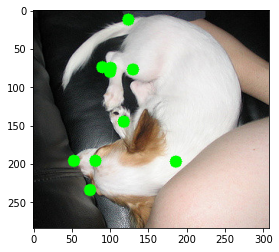

In [35]:
for i in range(0, len(pred), 3):
    if pred[i+2] > 0.75:
        x = int(pred[i] * (x_max-x_min))
        y = int(pred[i+1] * (y_max-y_min))
        cv2.circle(image, (x, y), 0, (0, 255, 0), 15)
plt.imshow(image)